In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add, Input, GlobalAveragePooling1D, Dense, MaxPooling1D
from tensorflow.keras.models import Model

In [4]:
def load_wave_data(data_dir):
    """
    指定されたディレクトリ内のすべてのpickleファイルの内容を読み込み、
    ラベルが複数あった場合は、条件に合わせてデータをコピーする。
    labelsが空の場合は、データを削除する。

    Args:
        data_dir (str): データディレクトリのパス

    Returns:
        list: pickleファイルの内容を格納したリスト
    """

    data = []
    for root, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if filename.endswith('.pickle'):
                file_path = os.path.join(root, filename)
                try:
                    with open(file_path, 'rb') as f:
                        data_list = pickle.load(f)
                        for item in data_list:
                            # labelsが空の場合はスキップ
                            if item['labels'].size == 0:
                                continue

                            # ラベルが複数ある場合の処理
                            if len(item['labels']) > 1:
                                if all(label == 0 for label in item['labels']):
                                    # ラベルがすべて0の場合は1つだけ残す
                                    data.append({
                                        'folder_name': item['folder_name'],
                                        'filename': item['filename'],
                                        'waveform_data': item['waveform_data'],
                                        'labels': item['labels'][0],  # ラベル0を1つだけ
                                        'label_positions': item['label_positions'][0]  # ラベル位置も1つだけ
                                    })
                                else:
                                    # ラベルが0と1の両方を含む場合はラベル1のデータのみ作成
                                    for i, label in enumerate(item['labels']):
                                        if label == 1:
                                            data.append({
                                                'folder_name': item['folder_name'],
                                                'filename': item['filename'],
                                                'waveform_data': item['waveform_data'],
                                                'labels': item['labels'][i],  # ラベル1を割り当て
                                                'label_positions': item['label_positions'][i]  # 対応するラベル位置を割り当て
                                            })
                            else:
                                # ラベルが1つだけの場合はそのまま追加
                                data.append(item)

                except Exception as e:
                    print(f"Error reading pickle file: {file_path}, {e}")
    return data

# データディレクトリのパス
data_dir = r'C:\Users\r-fujita\Desktop\ET\藤澤さんデータ\リスト1課\pickle_data'

# pickleファイルの内容を読み込む
data = load_wave_data(data_dir)

In [9]:
len(data)

12993

In [74]:
import random

def create_wave_dataset(data, window_size=200):
    """
    波形データを任意の幅で切り出し、AI学習用のデータセットを作成する。
    データ長が足りない場合は、その切り出しデータは採用しない。

    Args:
        data (list): 元データのリスト
        window_size (int): 切り出すデータの幅

    Returns:
        list: 切り出したデータのリスト
    """

    wave_dataset = []
    for item in data:
        waveform_data = item['waveform_data']
        data_length = len(waveform_data)

        if item['labels'] == 0:
            # 正常データ
            start_index = int(data_length * 0.2)
            end_index = int(data_length * 0.8)
            available_length = end_index - start_index - window_size + 1
            
            # 切り出し箇所を決定
            if available_length > 0:  # データ長が足りる場合のみ切り出す
                max_crop_num = min(5, available_length // window_size)  # 最大5か所
                crop_positions = random.sample(range(available_length), max_crop_num)
                crop_positions = [pos + start_index for pos in crop_positions]  # 位置を調整

                # データを切り出す
                for pos in crop_positions:
                    windowed_data = waveform_data[pos: pos + window_size]
                    label_position = pos + window_size // 2

                    wave_dataset.append({
                        'folder_name': item['folder_name'],
                        'filename': item['filename'],
                        'waveform_data': windowed_data,
                        'labels': item['labels'],
                        'label_position': label_position
                    })

        else:  # item['labels'] == 1:
            # 異常データ
            # label_positionsが配列の場合は最初の要素を取得、スカラーの場合はそのまま
            center = item['label_positions'][0] // 2 if isinstance(item['label_positions'], np.ndarray) else item['label_positions'] // 2
            start = int(max(0, center - window_size // 2))
            end = start + window_size

            # データ長が足りる場合のみ切り出す
            if end <= data_length:
                windowed_data = waveform_data[start:end]
                wave_dataset.append({
                    'folder_name': item['folder_name'],
                    'filename': item['filename'],
                    'waveform_data': windowed_data,
                    'labels': item['labels'],
                    'label_position': center  # 中心位置を保存
                })

    return wave_dataset

# 波形データの切り出し
wave_dataset = create_wave_dataset(data)

In [66]:
# labelsの値をリストにまとめる
all_labels = np.array([item['labels'] if np.isscalar(item['labels']) else item['labels'][0] for item in data]) # NumPy配列に変換

# dataをトレーニングデータとテストデータに分割 (8:2, stratifyを使用)
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=all_labels
)

# トレーニングデータを保存
with open('train_data.pickle', 'wb') as f:
    pickle.dump(train_data, f)

# テストデータを保存
with open('test_data.pickle', 'wb') as f:
    pickle.dump(test_data, f)

In [1]:
import pickle

# data.pickleを読み込む
with open(r'C:\Users\r-fujita\Desktop\ET\Phase3\data.pickle', 'rb') as f:  # 絶対パスを指定
    data = pickle.load(f)
    
# train_data.pickleを読み込む
with open(r'C:\Users\r-fujita\Desktop\ET\Phase3\train_data.pickle', 'rb') as f:  # 絶対パスを指定
    train_data = pickle.load(f)

# test_data.pickleを読み込む
with open(r'C:\Users\r-fujita\Desktop\ET\Phase3\test_data.pickle', 'rb') as f:  # 絶対パスを指定
    test_data = pickle.load(f)

In [2]:
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\r-fujita\Desktop\ET\Phase3\resnet_model_phase3.h5")

In [111]:
from sklearn.model_selection import train_test_split

# wave_datasetをトレーニングデータとテストデータに分割 (8:2, stratifyを使用)
train_data, test_data = train_test_split(
    wave_dataset, test_size=0.2, random_state=42, stratify=np.ravel([item['labels'] if np.isscalar(item['labels']) else item['labels'][0] for item in wave_dataset])
)

# トレーニングデータとテストデータのラベルをカウント
train_total_count, train_label_0_count, train_label_1_count = count_labels(train_data)
test_total_count, test_label_0_count, test_label_1_count = count_labels(test_data)

# 結果を表示
print("トレーニングデータ:")
print(f"  総数: {train_total_count}")
print(f"  ラベル0の数: {train_label_0_count}")
print(f"  ラベル1の数: {train_label_1_count}")

print("テストデータ:")
print(f"  総数: {test_total_count}")
print(f"  ラベル0の数: {test_label_0_count}")
print(f"  ラベル1の数: {test_label_1_count}")

トレーニングデータ:
  総数: 35512
  ラベル0の数: 34551
  ラベル1の数: 961
テストデータ:
  総数: 8879
  ラベル0の数: 8639
  ラベル1の数: 240


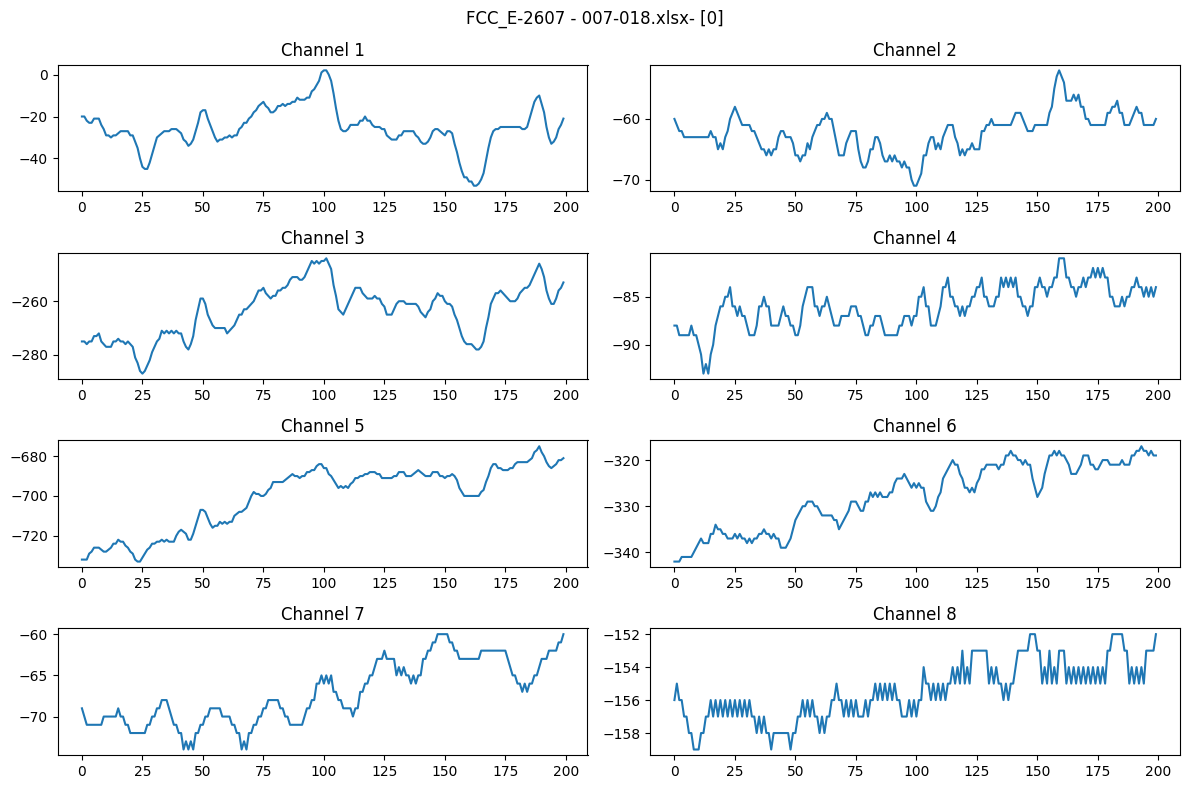

In [3]:
import matplotlib.pyplot as plt

def plot_waveform_data(data):
    """
    train_dataの"waveform_data"をプロットする。

    Args:
        data (dict): train_dataの要素
    """

    waveform_data = data['waveform_data']
    num_channels = waveform_data.shape[1]  # チャンネル数
    
    fig, axes = plt.subplots(4, 2, figsize=(12, 8))  # 4行2列のサブプロットを作成
    fig.suptitle(f"{data['folder_name']} - {data['filename']}- {data['labels']}")  # グラフのタイトルを設定

    for i in range(num_channels):
        row = i // 2  # 行番号を計算
        col = i % 2   # 列番号を計算
        ax = axes[row, col]
        ax.plot(waveform_data[:, i])  # i番目のチャンネルのデータを描画
        ax.set_title(f"Channel {i+1}")  # サブプロットのタイトルを設定

    plt.tight_layout()  # サブプロット間の余白を調整
    plt.show()

# train_dataの最初の要素をプロット
plot_waveform_data(train_data[50])

In [97]:
# トレーニングデータを保存
with open('train_data.pickle', 'wb') as f:
    pickle.dump(train_data, f)

# テストデータを保存
with open('test_data.pickle', 'wb') as f:
    pickle.dump(test_data, f)

In [5]:
def resnet_block(input_tensor, filters, kernel_size, stride=1):
    """
    ResNetブロックを構築します。

    Args:
        input_tensor (Tensor): 入力テンソル
        filters (int): フィルターの数
        kernel_size (int): カーネルサイズ
        stride (int): ストライド

    Returns:
        Tensor: 出力テンソル
    """
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Add, GlobalAveragePooling1D, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def create_resnet_model(input_shape):
    """
    ResNetモデルを構築します。

    Args:
        input_shape (tuple): 入力形状

    Returns:
        Model: ResNetモデル
    """
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, filters=64, kernel_size=3)
    x = resnet_block(x, filters=128, kernel_size=3, stride=2)
    x = resnet_block(x, filters=256, kernel_size=3, stride=2)
    x = resnet_block(x, filters=512, kernel_size=3, stride=2)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# モデルの構築
input_shape = (200, 8)
model = create_resnet_model(input_shape)

# モデルのコンパイル
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# X_trainとY_trainにデータを格納
X_train = np.array([item['waveform_data'] for item in train_data])
y_train = np.array([item['labels'][0] if isinstance(item['labels'], np.ndarray) else item['labels'] for item in train_data]) 
X_test = np.array([item['waveform_data'] for item in test_data])
y_test = np.array([item['labels'][0] if isinstance(item['labels'], np.ndarray) else item['labels'] for item in test_data]) 
# モデルの学習
history = model.fit(X_train, y_train, epochs=50,batch_size=32, validation_data=(X_test,y_test))

# モデルの評価
y_pred = model.predict(X_test)  # テストデータで予測
y_pred = np.round(y_pred).astype(int)  # 予測値を0または1に丸める

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Epoch 1/50
1110/1110 [==============================] - 41s 35ms/step - loss: 0.0713 - accuracy: 0.9796 - val_loss: 0.1213 - val_accuracy: 0.9789
Epoch 2/50
1110/1110 [==============================] - 39s 35ms/step - loss: 0.0324 - accuracy: 0.9905 - val_loss: 0.0215 - val_accuracy: 0.9948
Epoch 3/50
1110/1110 [==============================] - 37s 33ms/step - loss: 0.0262 - accuracy: 0.9925 - val_loss: 0.0384 - val_accuracy: 0.9928
Epoch 4/50
1110/1110 [==============================] - 36s 32ms/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.0169 - val_accuracy: 0.9956
Epoch 5/50
1110/1110 [==============================] - 40s 36ms/step - loss: 0.0190 - accuracy: 0.9945 - val_loss: 0.0247 - val_accuracy: 0.9944
Epoch 6/50
1110/1110 [==============================] - 41s 37ms/step - loss: 0.0165 - accuracy: 0.9953 - val_loss: 0.0164 - val_accuracy: 0.9952
Epoch 7/50
1110/1110 [==============================] - 41s 37ms/step - loss: 0.0157 - accuracy: 0.9953 - val_loss: 0.0148 -

In [13]:
# モデルの保存
model.save('resnet_model_phase3.h5')

In [11]:
# モデルの呼び出し
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\r-fujita\Desktop\ET\Phase3\resnet_model_phase3.h5")

In [60]:
# test_dataに使用されたデータのみに対して推論
test_data_keys = {(item['folder_name'], item['filename']) for item in test_data}
predict_test = [item for item in data if (item['folder_name'], item['filename']) in test_data_keys]
train_data_keys = {(item['folder_name'], item['filename']) for item in train_data}
predict_train = [item for item in data if (item['folder_name'], item['filename']) in train_data_keys]

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def predict_full_length_data(model, data, window_size=200):
    """
    全長データに対してスライディングウィンドウで推論を行う。

    Args:
        model: 学習済みモデル
        data (list): 全長データのリスト
        window_size (int): ウィンドウサイズ

    Returns:
        list: 全長データに対する推論結果のリスト
    """

    results = []
    for item in data:
        waveform_data = item['waveform_data']
        data_length = len(waveform_data)

        # スライディングウィンドウでデータを分割
        windows = []
        for i in range(0, data_length - window_size + 1, 1):  # 1ずつスライド
            window = waveform_data[i: i + window_size]
            windows.append(window)

        # 各ウィンドウに対して推論 (ループの外でmodel.predictを呼び出す)
        predictions = model.predict(np.array(windows), batch_size=512)  # バッチ処理
        results.append(predictions)

    return results

def plot_waveform_with_prediction(data, predictions, top_n=10):
    """
    波形データと推論結果をプロットする。

    Args:
        data (dict): 波形データ
        predictions (np.ndarray): 推論結果
        top_n (int): 矢印を付ける上位n個
    """

    waveform_data = data['waveform_data']
    num_channels = waveform_data.shape[1]
    data_length = len(waveform_data)

    fig, axes = plt.subplots(4, 2, figsize=(12, 8))
    fig.suptitle(f"{data['folder_name']} - {data['filename']}- {data['labels']}-{data['label_positions']//2}")

    for i in range(num_channels):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        ax.plot(waveform_data[:, i])
        ax.set_title(f"Channel {i+1}")
        ax.set_ylim(-1000, 1000)  # y軸の範囲を-1000～1000に設定

        # 推論結果の上位top_n個に矢印を付ける
        top_indices = np.argsort(predictions[:, 0])[-top_n:]  # 推論結果の上位top_n個のインデックスを取得
        for j in top_indices:
            center = j + 100  # ウィンドウの中心位置
            ax.annotate(
                '', xy=(center, -800), xytext=(center, -1000),  # 矢印のy座標を調整
                arrowprops=dict(facecolor='red', shrink=0.05,)  # widthを0.5に設定
            )

        # ラベル位置に青矢印を表示 (すべてのチャンネルに表示)
        label_pos = data['label_positions'] // 2
        ymin, ymax = ax.get_ylim()  # y軸の範囲を取得
        arrow_y = ymax  # 矢印のy座標を波形の上側に設定

        ax.annotate(
            '', xy=(label_pos, arrow_y), xytext=(label_pos, arrow_y + 100),  # 矢印のy座標を調整
            arrowprops=dict(facecolor='blue', shrink=0.05)
        )

    plt.tight_layout()


# 保存先ディレクトリ
save_dir = r"C:\Users\r-fujita\Desktop\ET\Phase3\prediction"
os.makedirs(save_dir, exist_ok=True)

# test_dataに使用したデータのみに対して推論
test_data_keys = {(item['folder_name'], item['filename']) for item in test_data}
target_data = [item for item in data if (item['folder_name'], item['filename']) in test_data_keys]

# 全てのデータに対して推論とプロット
for item in target_data:
    predictions = predict_full_length_data(model, [item])  # 推論
    plot_waveform_with_prediction(item, predictions[0])  # プロット

    # プロット結果をjpgファイルとして保存
    # dataの情報を使用
    filename = f"{item['folder_name']} - {item['filename']}.jpg"  
    plt.savefig(os.path.join(save_dir, filename))
    plt.close()  # メモリリークを防ぐために、プロットを閉じる

32/32 [==============================] - 0s 10ms/step


In [14]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

def predict_full_length_data(model, data, window_size=200):
    """
    全長データに対してスライディングウィンドウで推論を行う。

    Args:
        model: 学習済みモデル
        data (list): 全長データのリスト
        window_size (int): ウィンドウサイズ

    Returns:
        list: 全長データに対する推論結果のリスト
    """

    results = []
    for item in data:
        waveform_data = item['waveform_data']
        data_length = len(waveform_data)

        # スライディングウィンドウでデータを分割
        windows = []
        for i in range(0, data_length - window_size + 1, 1):  # 1ずつスライド
            window = waveform_data[i: i + window_size]
            windows.append(window)

        # 各ウィンドウに対して推論 (ループの外でmodel.predictを呼び出す)
        predictions = model.predict(np.array(windows), batch_size=512)  # バッチ処理
        results.append(predictions)

    return results

def plot_waveform_with_prediction(data, predictions, threshold=0.9):
    """
    波形データと推論結果をプロットする。

    Args:
        data (dict): 波形データ
        predictions (np.ndarray): 推論結果
        threshold (float): しきい値
    """

    waveform_data = data['waveform_data']
    num_channels = waveform_data.shape[1]
    data_length = len(waveform_data)

    fig, axes = plt.subplots(4, 2, figsize=(12, 8))
    fig.suptitle(f"{data['folder_name']} - {data['filename']}- {data['labels']}-{data['label_positions']//2}")

    for i in range(num_channels):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        ax.plot(waveform_data[:, i])
        ax.set_title(f"Channel {i+1}")
        ax.set_ylim(-1000, 1000)  # y軸の範囲を-1000～1000に設定

        # しきい値を超えたウィンドウの中心位置に矢印を付ける
        for j, pred in enumerate(predictions):
            if pred > threshold:
                center = j + 100  # ウィンドウの中心位置
                ax.annotate(
                    '', xy=(center, -800), xytext=(center, -1000),  # 矢印のy座標を調整
                    arrowprops=dict(facecolor='red', shrink=0.05)
                )

        # ラベル位置に青矢印を表示 (すべてのチャンネルに表示)
        label_pos = data['label_positions'] // 2
        ymin, ymax = ax.get_ylim()  # y軸の範囲を取得
        arrow_y = ymax  # 矢印のy座標を波形の上側に設定

        ax.annotate(
            '', xy=(label_pos, arrow_y), xytext=(label_pos, arrow_y + 100),  # 矢印のy座標を調整
            arrowprops=dict(facecolor='blue', shrink=0.05)
        )

    plt.tight_layout()

# 保存先ディレクトリ
save_dir = r"C:\Users\r-fujita\Desktop\ET\藤澤さんデータ\リスト1課\prediction"
os.makedirs(save_dir, exist_ok=True)

# dataからランダムに2000個のデータを選択
if len(data) > 2000:
    random_data = random.sample(data, 2000)
else:
    random_data = data

# 全てのデータに対して推論とプロット
for item in random_data:  # random_dataに変更
    predictions = predict_full_length_data(model, [item])  # 推論
    plot_waveform_with_prediction(item, predictions[0])  # プロット

    # プロット結果をjpgファイルとして保存
    # dataの情報を使用
    filename = f"{item['folder_name']} - {item['filename']}.jpg"  
    plt.savefig(os.path.join(save_dir, filename))
    plt.close()  # メモリリークを防ぐために、プロットを閉じる

19/19 [==============================] - 0s 13ms/step


In [9]:
import os
import numpy as np
from tensorflow.keras.models import load_model

def predict_full_length_data(model, data, window_size=200):
    """
    全長データに対してスライディングウィンドウで推論を行う。

    Args:
        model: 学習済みモデル
        data (list): 全長データのリスト
        window_size (int): ウィンドウサイズ

    Returns:
        list: 全長データに対する推論結果のリスト
    """

    results = []
    for item in data:
        waveform_data = item['waveform_data']
        data_length = len(waveform_data)

        # スライディングウィンドウでデータを分割
        windows = []
        for i in range(0, data_length - window_size + 1, 1):  # 1ずつスライド
            window = waveform_data[i: i + window_size]
            windows.append(window)

        # 各ウィンドウに対して推論 (ループの外でmodel.predictを呼び出す)
        predictions = model.predict(np.array(windows), batch_size=512)  # バッチ処理
        results.append(predictions)

    return results

# test_dataに使用したデータのみに対して推論
test_data_keys = {(item['folder_name'], item['filename']) for item in test_data}
target_data = [item for item in data if (item['folder_name'], item['filename']) in test_data_keys]

# 全てのデータに対して推論
no_anomaly_count = 0
for item in target_data:
    predictions = predict_full_length_data(model, [item])  # 推論

    # 異常部が検出されなかったデータの個数をカウント
    if np.max(predictions[0]) < 0.9:  # しきい値は0.9とする
        no_anomaly_count += 1

# 異常部が検出されなかったデータの個数を表示
print(f"異常部が検出されなかったデータの個数: {no_anomaly_count}")

32/32 [==============================] - 0s 7ms/step
異常部が検出されなかったデータの個数: 1304


In [70]:
import collections

def count_unique_data(test_data):
    """
    test_data の folder_name と filename の組み合わせの重複を考慮した長さを返す。

    Args:
        test_data (list): テストデータのリスト

    Returns:
        int: 重複を考慮した長さ
    """
    
    # folder_nameとfilenameの組み合わせをキーにした辞書を作成
    data_dict = collections.defaultdict(list)
    for item in test_data:
        key = (item['folder_name'], item['filename'])
        data_dict[key].append(item)
    
    # キーの数を返す
    return len(data_dict)

# test_data の長さを調べる
length = count_unique_data(test_data)

# 結果を表示
print(f"test_data の長さ: {length}")

test_data の長さ: 6039


In [81]:
import os
import shutil
import pandas as pd

def move_abnormal_images(test_data, image_dir, dest_dir):
    """
    test_data の labels が 1 の folder_name と filename をリストアップし、
    対応する画像ファイルを別のフォルダに移動する。

    Args:
        test_data (list): テストデータのリスト
        image_dir (str): 画像ファイルが保存されているディレクトリ
        dest_dir (str): 画像ファイルを移動する先のディレクトリ
    """

    # labels が 1 のデータを抽出
    abnormal_data = [item for item in test_data if item['labels'] == 0]

    # folder_name の昇順、次に filename の昇順でソート
    sorted_data = sorted(abnormal_data, key=lambda item: (item['folder_name'], item['filename']))

    # 画像ファイルを移動
    for item in sorted_data:
        folder_name = item['folder_name']
        filename = item['filename']
        # src_path を作成する際に、filename から .xlsx を削除
        src_path = os.path.join(image_dir, f"{folder_name} - {filename.replace('.xlsx', '')}.jpg")
        dest_path = os.path.join(dest_dir, f"{folder_name} - {filename.replace('.xlsx', '')}.jpg")

        # ファイルが存在する場合は移動
        if os.path.exists(src_path):
            shutil.move(src_path, dest_path)
        else:
            print(f"Error: File not found - {src_path}")

# 画像ファイルが保存されているディレクトリ
image_dir = r"C:\Users\r-fujita\Desktop\ET\Phase3\0.90_predictions"

# 画像ファイルを移動する先のディレクトリ
dest_dir = r"C:\Users\r-fujita\Desktop\ET\Phase3\0.90_normal_images"

# labels が 1 の画像ファイルを移動
move_abnormal_images(test_data, image_dir, dest_dir)

Error: File not found - C:\Users\r-fujita\Desktop\ET\Phase3\predictions\HD7_E910 - 004-006.jpg
Error: File not found - C:\Users\r-fujita\Desktop\ET\Phase3\predictions\HD7_E910 - 015-005.jpg
Error: File not found - C:\Users\r-fujita\Desktop\ET\Phase3\predictions\HS_E-122B - 034-002.jpg


In [76]:
import os

def remove_xlsx_from_filenames(dir_path):
  """
  指定されたディレクトリ内のファイル名から .xlsx を削除する。

  Args:
    dir_path (str): ディレクトリのパス
  """

  for filename in os.listdir(dir_path):
    if filename.endswith(".jpg"):  # .jpg ファイルのみを対象とする
      new_filename = filename.replace(".xlsx", "")  # .xlsx を削除
      old_path = os.path.join(dir_path, filename)
      new_path = os.path.join(dir_path, new_filename)
      os.rename(old_path, new_path)  # ファイル名を変更

# 画像ファイルが保存されているディレクトリ
image_dir = r"C:\Users\r-fujita\Desktop\ET\Phase3\predictions"  # 適宜変更してください

# ファイル名から .xlsx を削除
remove_xlsx_from_filenames(image_dir)

In [ ]:
import os
import shutil
import pandas as pd

def move_abnormal_images(test_data, image_dir, dest_dir):
    """
    test_data の labels が 1 の folder_name と filename をリストアップし、
    対応する画像ファイルを別のフォルダに移動する。

    Args:
        test_data (list): テストデータのリスト
        image_dir (str): 画像ファイルが保存されているディレクトリ
        dest_dir (str): 画像ファイルを移動する先のディレクトリ
    """

    # labels が 1 のデータを抽出
    abnormal_data = [item for item in test_data if item['labels'] == 1]

    # folder_name の昇順、次に filename の昇順でソート
    sorted_data = sorted(abnormal_data, key=lambda item: (item['folder_name'], item['filename']))

    # folder_name と filename をリストに抽出
    folder_names = [item['folder_name'] for item in sorted_data]
    filenames = [item['filename'] for item in sorted_data]

    # データフレームを作成
    df = pd.DataFrame({'folder_name': folder_names, 'filename': filenames})

    # Excelファイルに出力
    df.to_excel('abnormal_data.xlsx', index=False)

    # 画像ファイルを移動
    for folder_name, filename in zip(folder_names, filenames):
        src_path = os.path.join(image_dir, f"{folder_name} - {filename.replace('.xlsx', '')}.jpg")
        dest_path = os.path.join(dest_dir, f"{folder_name} - {filename.replace('.xlsx', '')}.jpg")

        # ファイルが存在する場合は移動
        if os.path.exists(src_path):
            shutil.move(src_path, dest_path)
        else:
            print(f"Error: File not found - {src_path}")

# 画像ファイルが保存されているディレクトリ
image_dir = r"C:\Users\r-fujita\Desktop\ET\Phase3\0.90_predictions"

# 画像ファイルを移動する先のディレクトリ
dest_dir = r"C:\Users\r-fujita\Desktop\ET\Phase3\0.90_normal_images"

# labels が 1 の画像ファイルを移動
move_abnormal_images(test_data, image_dir, dest_dir)

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

def create_data_pickle(data_dir, folder_name):
    """
    指定されたフォルダ内の波形データ、ラベル、ラベル位置をpickleファイルに保存します。

    Args:
        data_dir (str): データディレクトリのパス
        folder_name (str): 処理対象のフォルダ名
    """

    excel_dir = os.path.join(data_dir, 'Data_Excel_copy', folder_name)
    judge_dir = os.path.join(data_dir, 'JUDGE_Excel_copy')
    judge_filepath = os.path.join(judge_dir, f"{folder_name}.xlsx")

    # 解析データを読み込み
    df_judge = pd.read_excel(judge_filepath, header=None)

    data = []
    for filename in os.listdir(excel_dir):
        if filename.endswith('.xlsx'):
            try:
                # 波形データを読み込み (2行目から全て)
                filepath = os.path.join(excel_dir, filename)
                df = pd.read_excel(filepath, header=0)  # headerを0に設定
                waveform_data = df.values

                # ファイル名からA列とB列の値を取得
                file_parts = filename.split('-')
                a_col = int(file_parts[0])
                b_col = int(file_parts[1].split('.')[0])

                # ラベル位置を取得 (複数ラベルに対応)
                label_positions = df_judge[
                    (df_judge[0] == a_col) & (df_judge[1] == b_col)
                ][11].values

                # ラベルを生成
                labels = np.where(label_positions == 0, 0, 1)

                # データをリストに追加
                data.append({
                    'folder_name': folder_name,
                    'filename': filename,
                    'waveform_data': waveform_data,
                    'labels': labels,
                    'label_positions': label_positions
                })

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # pickleファイルに保存
    save_dir = os.path.join(data_dir, 'pickle_data')
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{folder_name}.pickle")
    with open(save_path, 'wb') as f:
        pickle.dump(data, f)

if __name__ == "__main__":
    data_dir = r"C:\Users\r-fujita\Desktop\ET\藤澤さんデータ\リスト1課"

    # 教師データExcelフォルダ内の全てのフォルダを処理
    excel_dir = os.path.join(data_dir, 'Data_Excel_copy')
    for folder_name in os.listdir(excel_dir):
        folder_path = os.path.join(excel_dir, folder_name)
        if os.path.isdir(folder_path):
            create_data_pickle(data_dir, folder_name)

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_waveform_data(data, save_dir):
    """
    waveform_data をプロットし、画像として保存する。

    Args:
        data (list): 波形データのリスト
        save_dir (str): 画像を保存するディレクトリ
    """

    os.makedirs(save_dir, exist_ok=True)  # 保存先ディレクトリを作成

    for item in data:
        if item['labels'] == 1:  # label が 1 のデータのみプロット
            waveform_data = item['waveform_data']
            num_channels = waveform_data.shape[1]
            data_length = len(waveform_data)

            fig, axes = plt.subplots(4, 2, figsize=(12, 8))
            fig.suptitle(f"{item['folder_name']} - {item['filename']}")

            for i in range(num_channels):
                row = i // 2
                col = i % 2
                ax = axes[row, col]
                ax.plot(waveform_data[:, i])
                ax.set_title(f"Channel {i+1}")
                ax.set_ylim(-1000, 1000)  # y軸の範囲を-1000～1000に設定

                # ラベル位置に矢印を表示
                label_pos = item['label_positions'] // 2
                ax.annotate(
                    '', xy=(label_pos, 0), xytext=(label_pos, -200),
                    arrowprops=dict(facecolor='red', shrink=0.05)
                )

            plt.tight_layout()

            # 画像を保存
            filename = f"{item['folder_name']} - {item['filename']}.jpg"
            plt.savefig(os.path.join(save_dir, filename))
            plt.close()  # メモリリークを防ぐために、プロットを閉じる

# 画像を保存するディレクトリ
save_dir = r"C:\Users\r-fujita\Desktop\ET\Phase3\waveform_plots"  # 適宜変更してください

# 波形データをプロット
plot_waveform_data(data, save_dir)

NameError: name 'data_length' is not defined

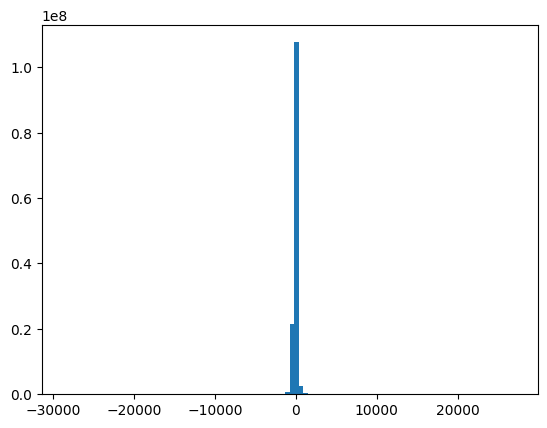

In [17]:
import matplotlib.pyplot as plt
import numpy as np

channel_6_data = []
for item in data:
    waveform_data = item['waveform_data']
    channel_6_data.extend(waveform_data[:, 5])  # 6ch目はインデックス5

channel_6_data = np.array(channel_6_data)  # NumPy配列に変換

plt.hist(channel_6_data, bins=100)  # binsはヒストグラムの棒の数
plt.xticks(np.arange(0, data_length, 100)) # 目盛りを0からdata_lengthまで100刻みで表示
plt.xlabel("Waveform Value")
plt.ylabel("Frequency")
plt.title("Histogram of Waveform Data (Channel 6)")
plt.show()